# Advanced QAOA parameter classes

Here we illustrate the use of the `Annealing` and `Fourier` parameter classes included in the `entropica_qaoa` package.

## Discussion:
 - The arguments `nshots` and `scalar_cost_function` default to `0` and `True` respectively, so they don't have to be passed explicitely. Do we pass them anyways, to indicate to the user that there are some more options, or do we remove them to get shorter and easier to understand code?
 - The argument `sim` is not neccesary anymore, if it is not passed `QAOACostFunctionOnWFSim` simply gets its own simulator connection. So the same question arises here again.
 - I found, that `Nelder-Mead` (the default for scipy.optimize.minimize) gets stuck in local minima quite often (at least with) the examples in `AdvancedQAOAParameterDemo` and I needed to pass `method="Cobyla"` often. Do we go with `Nelder-Mead` anyways, because the correct choice of an optimizer is a question that is more appropriate for the more advanced Notebooks?
 - The part about the perturbations and Fourier being better for NISQ is to be taken with a grain of salt: Changing one of the fourier parameters changes the resulting rotation angles in a correlated, smooth fashion. But the gate noise we see in NISQ technology won't be of that kind!

In [1]:
# import the standard modules from python
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# import the neccesary pyquil modules
from pyquil.api import local_qvm, WavefunctionSimulator
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.unitary_tools import lifted_pauli

# import the QAOAParameters classes 
from entropica_qaoa.qaoa.parameters import AbstractParams, AnnealingParams, StandardParams, FourierParams
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnWFSim
from entropica_qaoa.utilities import *

# turn off matplotlib warnings associated with networkx
import warnings
warnings.filterwarnings("ignore")

# Set up the WavefunctionSimulator object
sim = WavefunctionSimulator()

## The `Annealing` parameter class

In quantum annealing, we start in the ground state of a _mixer_ (or _reference_) Hamiltonian $H_M$, and gradually transform to the ground state of a _cost_ Hamiltonian $H_C$, according to some annealing schedule function $s(t)$, where $t$ denotes time. If it were possible to perform the transformation infintessimally slowly, we would be guaranteed to arrive at the exact ground state of the cost Hamiltonian. In practice, the transformation is performed over some finite time, and we hope to prepare the ground state of $H_C$ with some acceptably high probability.

At any time $t$ during the procedure, the instantaneous Hamiltonian is given by

\begin{equation}
H(t) = \left(1 - s(t)\right)H_M + s(t)H_C
\end{equation}

where $s(0) = 0$, and $s(t = T) = 1$, and $T$ is the total annealing time. We see that the strengths with which $H_M$ and $H_C$ act at a given time are related: the mixer is applied with a weight $(1 - s(t))$, and the cost Hamiltonian with weight $s(t)$. It is common to view the QAOA as a form of discretised annealing, where the procedure is performed in a fixed number of steps $p$. However, the coefficients of the mixer and cost Hamiltonians need not be related in the simple way that they are in a conventional annealing schedule. 

The `AnnealingParams` parameter class illustrates what is perhaps the first conceptual step from annealing, towards the more conventionally used parametrisations of QAOA. Using `AnnealingParams`, we prepare an output quantum state with a circuit described by the unitary operator

\begin{equation}
U = \exp\left(-i(1-s(t_p)) H_M \Delta t\right)\exp\left(-i s(t_p) H_C \Delta t\right) \cdots \exp\left(-i(1-s(t_1))H_M \Delta t\right) \exp\left(-i s(t_1) H_C \Delta t\right)
\end{equation}

Here, we have a fixed temporal step of size $\Delta t$, and we need to specify what the values of the annealing schedule function should be at the different timesteps. That is, we need to provide a list of the values of $s(t_i$) for $i = 1,..,p$.

Here we illustrate the use of the `AnnealingParams` class, whose value we envisage primarily as a didactic or research tool. Specifically, let's compare the annealing parametrisation with the `StandardParams` parametrisation.

First, we set up the Hamiltonian as usual.

In [2]:
# Create a hamiltonian on 3 qubits with 2 coupling terms and 1 bias term
Term1 = PauliTerm("Z", 0, 0.7)*PauliTerm("Z", 1)
Term2 = PauliTerm("Z", 0, 1.2)*PauliTerm("Z", 2)
Term3 = PauliTerm("Z", 0, -0.5)

hamiltonian = PauliSum([Term1,Term2,Term3])
print("hamiltonian =", hamiltonian)

hamiltonian = (0.7+0j)*Z0*Z1 + (1.2+0j)*Z0*Z2 + (-0.5+0j)*Z0


We'll use the `linear_ramp_from_hamiltonian` method to determine the values of the function $s$ at the different timesteps.

In [3]:
p = 5
linear_annealing_params = AnnealingParams.linear_ramp_from_hamiltonian(hamiltonian, p)
print(linear_annealing_params)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	schedule: [0.1 0.3 0.5 0.7 0.9]


Now let's optimise the cost function and examine the corresponing output parameters.

expectation value =  -3.5512684287201868


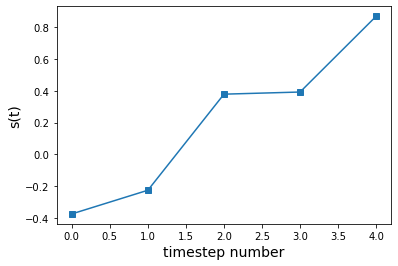

In [4]:
# set up the cost function
cost_anneal = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=linear_annealing_params,
                                        sim=sim,
                                        scalar_cost_function=True, 
                                        nshots=1)

# and optimize the parameters
res_anneal = minimize(cost_anneal, linear_annealing_params.raw(), method="Cobyla")

print("expectation value = ", res_anneal.fun)

linear_annealing_params.update_from_raw(res_anneal.x)
linear_annealing_params.plot()

Now let's solve the same problem using `StandardParams`.

expectation value =  -2.225164320372563


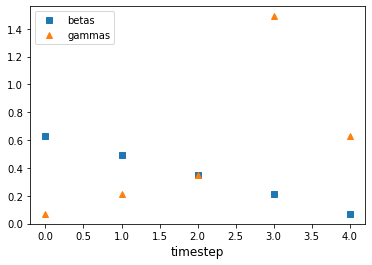

In [5]:
standard_params = StandardParams.linear_ramp_from_hamiltonian(hamiltonian,p)

cost_standard = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=standard_params,
                                        sim=sim,
                                        scalar_cost_function=True,
                                        nshots=1)

res_std = minimize(cost_standard, standard_params.raw(), method="Cobyla")

print("expectation value = ", res_std.fun)
standard_params.update_from_raw(res_std.x)
standard_params.plot()

Notice that at least for this simple problem, the expectation values obtained are comparable, yet we use half the number of parameters in `AnnealingParams` as `StandardParams`.

In the optimal `StandardParams`, we see a rather erratic but overall downward (upward) trend in the betas (gammas), which is conistent with the annealing picture that the mixer Hamiltonian is gradually turned off, and the cost Hamiltonian is gradually turned on. 

Following [Ref 1](#references), we can attempt to make a connection between the two pictures, by interpreting the sum of all the betas and all the gammas as a total annealing time. We can then define the corresponding annealing schedule function value at each time as

\begin{equation}
s(t_i) = \frac{\gamma_i}{\beta_i + \gamma_i}
\end{equation}

When we plot this function, we see a similar behaviour to that observed above.

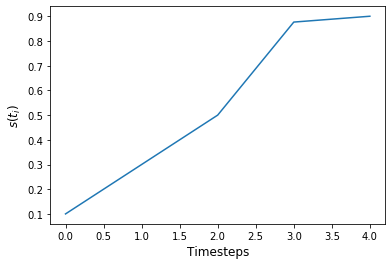

In [6]:
opt_betas = standard_params.betas
opt_gammas = standard_params.gammas
hybrid_params = [opt_gammas[i]/(opt_gammas[i] + opt_betas[i]) for i in range(p)]

plt.plot(range(p),hybrid_params)
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('$s(t_i)$', fontsize=12)
plt.show()

## The `Fourier` parameter class

This parameter class originated from attempts to find heuristic ways of reducing the number of parameters required to perform QAOA. Based on empirical observations in patterns of the optimal QAOA angles, Zhuo et al (see [Ref 1](#references)) proposed considering the discrete Fourier transforms of `betas` and `gammas` as an alternative, more economical parametrisation.

The basic idea kicks off from  the conventional QAOA parametrisation, i.e. what we call the `StandardParams` class. Here, at each iteration in QAOA we have one angle for all of the mixer Hamiltonian terms, and one angle for all of the cost Hamiltonian terms. That is, the `StandardParams` parametrisation requires the specification of $2p$ numbers, a `beta` and a `gamma` for each timestep.

In the Fourier representation, we switch instead to a set of $2q$ parameters, denoted $\vec{v}$ and $\vec{u}$, which are related to $\vec{\beta}$ and $\vec{\gamma}$ by

\begin{eqnarray}
\beta_i^{(p)} &=& \sum_{k=1}^q v_k \cos\left[ \left(k - \frac{1}{2}\right) \left(i - \frac{1}{2}\right) \frac{\pi}{p} \right]\\
\gamma_i^{(p)} &=& \sum_{k=1}^q u_k \sin\left[ \left(k - \frac{1}{2}\right) \left(i - \frac{1}{2}\right) \frac{\pi}{p} \right]
\end{eqnarray}

where $i = 1,...,p$. The insight of Zhou et al is that the optimal parameters found are often empirically seen to be smoothly varying functions for certain problems, and that it should then be possible to use a reduced parameter set consisting of only the lowest $q$ frequency components of those functions. Clearly, for $q\geq p$ we have the full expressivity of the original parameter set (i.e. the $\beta$s and $\gamma$s). In this parametrisation, for fixed $q$, the optimisation problem therefore becomes that of finding the optimal Fourier components $v_k$ and $u_k$. 

In [Ref 1](#references), the authors show that certain variants of this basic Fourier parametrisation can perform significantly better than a  randomised brute force search through parameter space, for MaxCut problems on 3-regular and 4-regular graphs. Here, we will compare `FourierParams` and `StandardParams` for different instances of a relatively small problem. 

We will consider 3-regular graphs on 8 nodes, and use the `linear_ramp_from_hamiltonian` method to generate intial parameters for each of the two classes. We generate a random problem instance, and find the optimial ground state energy returned using the two parametrisations. We then compute the relative error of each from the true ground state energy. 

First define a convenience function:

In [7]:
def randgraph_fourier_std(degree,nodes,p,q):
    
    # Generate a random graph
    graph = random_k_regular_graph(degree, nodes, weighted=True)
    hamiltonian = hamiltonian_from_graph(graph)
    
    # Get ground state energy
    hamiltonian_matrix = lifted_pauli(hamiltonian, hamiltonian.get_qubits())
    ground_energy = min(np.linalg.eigvals(hamiltonian_matrix))
    
    # Define Fourier params and run optimisation
    fourier_params = FourierParams.linear_ramp_from_hamiltonian(hamiltonian, p, q)
    cost_fourier = QAOACostFunctionOnWFSim(hamiltonian, params=fourier_params, sim=sim)
    res_fourier = minimize(cost_fourier, fourier_params.raw())
    
    # Define Standard params and run optimisation
    std_params = StandardParams.linear_ramp_from_hamiltonian(hamiltonian, p)
    cost_std = QAOACostFunctionOnWFSim(hamiltonian, params=std_params, sim=sim)
    res_std = minimize(cost_std, std_params.raw())
    
    return res_fourier, res_std, ground_energy, hamiltonian

We'll start by setting $p=q$, where in principle the `FourierParams` and the `StandardParams` have equal expressivity.

[JL] Any way to speed up the next cell or make a shorter Demo? If it takes 20 minutes we can't realistically test this notebook every time we need to

In [8]:
p = 3
q = 3

samples = 1 # Note: with samples = 20, this cell should take around 5 minutes to run on a standard laptop.

err_fourier = np.zeros(samples)
err_std = np.zeros(samples)

for i in range(samples):
    
    res_fourier, res_std, ground_energy, _ = randgraph_fourier_std(3, 8, p, q)

    # Compute relative error 
    err_fourier[i] = np.absolute((res_fourier.fun - ground_energy)/ground_energy)
    err_std[i] = np.absolute((res_std.fun - ground_energy)/ground_energy)
    
print("Mean error using FourierParams: ", np.mean(err_fourier))
print("Mean error using StandardParams: ", np.mean(err_std))

Mean error using FourierParams:  0.15815617406245858
Mean error using StandardParams:  0.1581561740627244


In the naive way we have applied it here, the `Fourier` parametrisation appears to perform worse than the `Standard` parametrisation. However, let's check how senstive the optimal parameters are to random perturbations. We'll do this by solving a fixed instance once to obtain the base case optimal parameters, `opt_fourier_params` and `opt_std_params`. We'll then randomly modify each of these and solve the problem again, in each case recording the relative error from the actual ground state energy.

In [9]:
res_fourier, res_std, ground_energy, hamiltonian = randgraph_fourier_std(3,8,p,q)

opt_fourier_params = res_fourier.x
opt_std_params = res_std.x


# Template set of Params to get right shape - but can get rid of the need to do this later.
fourier_template = FourierParams.linear_ramp_from_hamiltonian(hamiltonian,p,q)
std_template = StandardParams.linear_ramp_from_hamiltonian(hamiltonian,p)

samples = 1

err_perturbed_fourier = np.zeros(samples)
err_perturbed_std = np.zeros(samples)

for i in range(samples):
    
    perturbed_fourier = opt_fourier_params + np.random.rand(len(opt_fourier_params))
    fourier_template.update_from_raw(perturbed_fourier) 
    cost_fourier = QAOACostFunctionOnWFSim(hamiltonian,params=fourier_template, sim=sim)
    res_fourier = minimize(cost_fourier, fourier_template.raw())
    
    perturbed_std = opt_std_params + np.random.rand(len(opt_std_params))
    std_template.update_from_raw(perturbed_std)
    cost_std = QAOACostFunctionOnWFSim(hamiltonian, params=std_template, sim=sim)
    res_std = minimize(cost_std, std_template.raw())
    
    err_perturbed_fourier[i] = np.absolute((res_fourier.fun - ground_energy)/ground_energy)
    err_perturbed_std[i] = np.absolute((res_std.fun - ground_energy)/ground_energy)
    
print("Mean error with perturbed FourierParams: ", np.mean(err_perturbed_fourier))
print("Mean error with perturbed StandardParams: ", np.mean(err_perturbed_std))

Mean error with perturbed FourierParams:  0.6979736494446532
Mean error with perturbed StandardParams:  0.2196564762190056


At least in this simple case, the optimal Fourier parameters seem to be significantly more robust to perturbations. In fact, if we examine the individual samples, we see that the Fourier parameters always give the same error, while the error in the Standard params can vary considerably:

In [10]:
print("Fourier errors: ", err_perturbed_fourier)
print("")
print("Standard errors: ", err_perturbed_std)

Fourier errors:  [0.69797365]

Standard errors:  [0.21965648]


Given that near-term quantum computers will be noisy, this apparent robustness of the Fourier parameters may be a desriable characteristic for QAOA applications, worthy of further investigation.

<a id='references'></a>

## References

1. L. Zhou et al, __[*Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices*](https://arxiv.org/abs/1812.01041)__